## <center> Machine Learning Project
## <center> Course: ML1    
#### <center> Instructor: Dr. Tariq Mahmood

### <center> Submitted By:
## <center> Muhammad Uzair 29414
#### <center> MS - Data Science (IBA)

#### <center> Dataset - Dropout v Academic
https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

# Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, auc, mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE


# Functions

In [197]:
def load_data(filepath):
    df = pd.read_csv(filepath, sep=';')
    return df

def class_label(df):
    # Assuming your dataset is stored in a variable called 'df'
    df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})
    return df

def clean_data(df):
    df_cleaned = df.dropna()
    return df_cleaned

def transform_data(df):
    scaler = StandardScaler()
    numerical_cols = df.select_dtypes(include=['float64']).columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

def eda(df):
    summary_stats = df.describe()
    float_cols = df.select_dtypes(include=['float64']).columns
    
    num_cols = len(float_cols)
    num_rows = (num_cols + 2) // 3
    
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(float_cols):
        plt.subplot(num_rows, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(float_cols):
        plt.subplot(num_rows, 3, i+1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


def manual_split(df, target_column):
    if isinstance(target_column, list):
        target_column = target_column[0]
    
    # One-hot encoding for categorical features
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    # Check if the target column is in the list of categorical columns
    if target_column in categorical_cols:
        # Remove the target column from the list of categorical columns
        categorical_cols.remove(target_column)
    # else:
    #     print(f"Target column '{target_column}' is not found in the DataFrame's categorical columns.")
    
    # Perform one-hot encoding excluding the target column
    df = pd.get_dummies(df, columns=categorical_cols)

    # Label encoding for the target variable
    label_encoder = LabelEncoder()
    df[target_column] = label_encoder.fit_transform(df[target_column])

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=[target_column]),
        df[target_column],
        test_size=0.3,
        random_state=1
    )
    return X_train, X_test, y_train, y_test
    
def cv_scores(model,X_train, y_train):  
    # Example: KNN Classifier
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return cv_scores
    
def train_model(model,X_train,y_train):
    model.fit(X_train, y_train)

def evaluate_model(model,X_test,y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    
    if len(np.unique(y_test)) > 2:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    else:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    return accuracy, classification_rep, roc_auc

# without CI

## Master Pipeline

In [189]:
def master_pipeline(filepath, target):
    df = load_data(filepath)
    df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    X_train, X_test, y_train, y_test = manual_split(df, target)
    
    # Model selection
    model = model_selection()

    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train, y_train)

    # Evaluate model without cross-validation
    print("\nEvaluating model without cross-validation...")
    acc_without_cv, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)

    print("\nResults without Cross-Validation:")
    print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_without_cv:.3f}")
    print(f"Accuracy: {acc_without_cv:.3f}")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train, y_train)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train, y_train)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")

In [6]:
# file path
filepath = 'dropout v academic.csv'
target = 'Target'

df1 = pd.read_csv(filepath, sep=';')



In [7]:
df1

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [191]:
df1['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

In [199]:
df1.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance\t                        int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

## Logistic Regression

In [195]:
def model_selection():
    model = LogisticRegression(max_iter = 1000000)
    print ('Logistic Regression')
    return model

In [196]:
master_pipeline(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})


Logistic Regression

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.857
F1 -ve: 0.792
AUC: 0.889
Accuracy: 0.769

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt


Cross-Validation Scores:
Fold 1: 0.771
Fold 2: 0.740
Fold 3: 0.746
Fold 4: 0.771
Fold 5: 0.780

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.857
F1 -ve: 0.792
AUC: 0.889
Accuracy: 0.769


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Naive Bayes

In [139]:
def model_selection():
    model = GaussianNB()
    print('Naive Bayes')
    return model

In [140]:
master_pipeline(filepath, target)

Naive Bayes

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.794
F1 -ve: 0.721
AUC: 0.798
Accuracy: 0.695

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.705
Fold 2: 0.669
Fold 3: 0.658
Fold 4: 0.711
Fold 5: 0.700

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.794
F1 -ve: 0.721
AUC: 0.798
Accuracy: 0.695


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})


## Decision Tree

In [143]:
def model_selection():
    model = DecisionTreeClassifier()
    print('Decision Tree')
    return model

In [144]:
master_pipeline(filepath,target)

Decision Tree

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.788
F1 -ve: 0.682
AUC: 0.727
Accuracy: 0.682

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})



Cross-Validation Scores:
Fold 1: 0.660
Fold 2: 0.649
Fold 3: 0.658
Fold 4: 0.667
Fold 5: 0.670

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.789
F1 -ve: 0.692
AUC: 0.730
Accuracy: 0.684


## Random Forest Classifier

In [145]:
def model_selection():
    model = RandomForestClassifier()
    print('Random Forest Classifier')
    return model

In [146]:
master_pipeline(filepath, target)

Random Forest Classifier

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})



Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.863
F1 -ve: 0.798
AUC: 0.893
Accuracy: 0.780

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.774
Fold 2: 0.750
Fold 3: 0.753
Fold 4: 0.764
Fold 5: 0.763

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.864
F1 -ve: 0.795
AUC: 0.891
Accuracy: 0.782


## Gradient Boosting Classifier

In [147]:
def model_selection():
    model = GradientBoostingClassifier()
    print('Gradient Boosting Classifier')
    return model

In [148]:
master_pipeline(filepath, target)

Gradient Boosting Classifier

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})



Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.868
F1 -ve: 0.793
AUC: 0.899
Accuracy: 0.787

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.773
Fold 2: 0.740
Fold 3: 0.754
Fold 4: 0.758
Fold 5: 0.769

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.868
F1 -ve: 0.793
AUC: 0.899
Accuracy: 0.787


## Results

|          | Logistic Regression | Naïve Bayes | Decision Tree | Random Forest Classifier | Gradient Boosting |
|------------------------|---------------------|-------------|---------------|--------------------------|-------------------|
| F1 +ve                 | 0.439               | 0.443       | 0.479         | 0.503                    | 0.498             |
| F1-ve                  | 0.946               | 0.913       | 0.930         | 0.949                    | 0.948             |
| AUC                    | 0.907               | 0.806       | 0.711         | 0.929                    | 0.926             |
| Accuracy               | 0.901               | 0.849       | 0.877         | 0.908                    | 0.906             |


# =====================================================
# Class Imbalance - Resampling Method (Random Under Sampling)

## Master Pipeline

In [149]:
def master_pipeline_with_resampling(filepath, target):
    df = load_data(filepath)
    df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    
    # Apply Random Undersampling
    X_train, X_test, y_train, y_test = manual_split(df, target)
    rus = RandomUnderSampler(random_state=1)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    
    # Model selection
    model = model_selection()

    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train_resampled, y_train_resampled)

    # Evaluate model without cross-validation
    print("\nEvaluating model without cross-validation...")
    acc_without_cv, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)

    print("\nResults without Cross-Validation:")
    print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_without_cv:.3f}")
    print(f"Accuracy: {acc_without_cv:.3f}")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train_resampled, y_train_resampled)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train_resampled, y_train_resampled)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")




## Logistic Regression with Random Under Sampling

In [152]:
def model_selection():
    model = LogisticRegression()
    print ('Logistic Regression with Random Under Sampling')
    return model

In [153]:
master_pipeline_with_resampling(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\uzairmuh\AppData\

Logistic Regression with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.786
F1 -ve: 0.657
AUC: 0.793
Accuracy: 0.671

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.


Cross-Validation Scores:
Fold 1: 0.566
Fold 2: 0.645
Fold 3: 0.581
Fold 4: 0.578
Fold 5: 0.625

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.786
F1 -ve: 0.657
AUC: 0.793
Accuracy: 0.671


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

## Naive Bayes with Random Under Sampling

In [154]:
def model_selection():
    model = GaussianNB()
    print('Naive Bayes with Random Under Sampling')
    return model

In [155]:
master_pipeline_with_resampling(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})


Naive Bayes with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.788
F1 -ve: 0.716
AUC: 0.791
Accuracy: 0.689

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.602
Fold 2: 0.648
Fold 3: 0.551
Fold 4: 0.614
Fold 5: 0.628

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.788
F1 -ve: 0.716
AUC: 0.791
Accuracy: 0.689


## Decision Tree Classifier with Random Under Sampling

In [158]:
def model_selection():
    model = DecisionTreeClassifier()
    print('Decision Tree with Random Under Sampling')
    return model

In [159]:
master_pipeline_with_resampling(filepath, target)

Decision Tree with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.718
F1 -ve: 0.660
AUC: 0.715
Accuracy: 0.627

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})



Cross-Validation Scores:
Fold 1: 0.578
Fold 2: 0.633
Fold 3: 0.590
Fold 4: 0.566
Fold 5: 0.592

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.704
F1 -ve: 0.667
AUC: 0.711
Accuracy: 0.620


## Random Forest Classifier with Random Under Sampling

In [160]:
def model_selection():
    model = RandomForestClassifier()
    print('Random Forest Classifier with Random Under Sampling')
    return model

In [161]:
master_pipeline_with_resampling(filepath,target)

Random Forest Classifier with Random Under Sampling

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})



Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.840
F1 -ve: 0.766
AUC: 0.892
Accuracy: 0.751

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.657
Fold 2: 0.729
Fold 3: 0.678
Fold 4: 0.672
Fold 5: 0.719

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.851
F1 -ve: 0.774
AUC: 0.892
Accuracy: 0.762


## Gradient Boosting Classifier with Random Under Sampling

In [162]:
def model_selection():
    model = GradientBoostingClassifier()
    print('Gradient Boosting Classifier with Random Under Sampling')
    return model

In [163]:
master_pipeline_with_resampling(filepath,target)

Gradient Boosting Classifier with Random Under Sampling

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})



Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.850
F1 -ve: 0.756
AUC: 0.892
Accuracy: 0.756

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.645
Fold 2: 0.711
Fold 3: 0.729
Fold 4: 0.675
Fold 5: 0.737

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.849
F1 -ve: 0.758
AUC: 0.892
Accuracy: 0.757


## Results

|          | Logistic Regression | Naïve Bayes | Decision Tree | Random Forest Classifier | Gradient Boosting |
|------------------------|---------------------|-------------|---------------|--------------------------|-------------------|
| F1 +ve                 | 0.786               | 0.788       | 0.791         | 0.704                    | 0.711             |
| F1-ve                  | 0.657               | 0.716       | 0.689         | 0.667                    | 0.620             |
| AUC                    | 0.793               | 0.791       | 0.704         | 0.711                    | 0.620             |
| Accuracy               | 0.671               | 0.689       | 0.667         | 0.711                    | 0.774             |


# =====================================================
# Class Imbalance - Class weight and Ensemble 

## Master Pipeline

In [164]:
def master_pipeline(filepath, target, strategy='class_weight'):
    df = load_data(filepath)
    df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    X_train, X_test, y_train, y_test = manual_split(df, target)
    
    # Model selection
    model = model_selection(strategy=strategy, y_train=y_train)
    
    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train, y_train)

    # Evaluate model without cross-validation
    print("\nEvaluating model without cross-validation...")
    acc_without_cv, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)

    print("\nResults without Cross-Validation:")
    print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_without_cv:.3f}")
    print(f"Accuracy: {acc_without_cv:.3f}")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train, y_train)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train, y_train)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")


## Logistic Regression (Class Weight)
## Gradient Boosting (Ensemble)

In [165]:
def model_selection(strategy='class_weight', y_train=None):
    if strategy == 'class_weight':
        if y_train is None:
            raise ValueError("If 'class_weight' strategy is selected, y_train must be provided.")
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
        model = LogisticRegression(class_weight=class_weights_dict,max_iter = 1000000)
        print('Logistic Regression with Class Weighting')
    elif strategy == 'ensemble':
        model = GradientBoostingClassifier()
        print('Gradient Boosting Classifier (Ensemble Method)')
    else:
        raise ValueError("Invalid strategy. Choose either 'class_weight' or 'ensemble'.")
    return model


In [166]:
master_pipeline(filepath, target, strategy='class_weight')

Logistic Regression with Class Weighting

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.848
F1 -ve: 0.779
AUC: 0.886
Accuracy: 0.763

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt


Cross-Validation Scores:
Fold 1: 0.739
Fold 2: 0.717
Fold 3: 0.724
Fold 4: 0.753
Fold 5: 0.730

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.848
F1 -ve: 0.779
AUC: 0.886
Accuracy: 0.763


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [167]:
master_pipeline(filepath, target, strategy='ensemble')

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})


Gradient Boosting Classifier (Ensemble Method)

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.868
F1 -ve: 0.793
AUC: 0.899
Accuracy: 0.787

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.773
Fold 2: 0.740
Fold 3: 0.754
Fold 4: 0.759
Fold 5: 0.769

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.868
F1 -ve: 0.793
AUC: 0.899
Accuracy: 0.787


## Balanced Random Forest (Class Weight)
## Easy Ensemble Classifier (Ensemble) 

In [168]:
def model_selection(strategy='class_weight', y_train=None):
    if strategy == 'class_weight':
        if y_train is None:
            raise ValueError("If 'class_weight' strategy is selected, y_train must be provided.")
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
        model = BalancedRandomForestClassifier(class_weight=class_weights_dict)
        print('Balanced Random Forest Classifier with Class Weighting')
    elif strategy == 'ensemble':
        model = EasyEnsembleClassifier()
        print('Easy Ensemble Classifier (Ensemble Method)')
    else:
        raise ValueError("Invalid strategy. Choose either 'class_weight' or 'ensemble'.")
    return model


In [169]:
master_pipeline(filepath, target, strategy='class_weight')

Balanced Random Forest Classifier with Class Weighting

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13.


Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.835
F1 -ve: 0.772
AUC: 0.884
Accuracy: 0.750

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p


Cross-Validation Scores:
Fold 1: 0.710
Fold 2: 0.750
Fold 3: 0.709
Fold 4: 0.740
Fold 5: 0.738

Training model with all data...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p


Evaluating model with all data...

Results with All Data:
F1 +ve: 0.839
F1 -ve: 0.752
AUC: 0.891
Accuracy: 0.745


In [170]:
master_pipeline(filepath, target, strategy='ensemble')

Easy Ensemble Classifier (Ensemble Method)

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})



Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.827
F1 -ve: 0.762
AUC: 0.875
Accuracy: 0.736

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.723
Fold 2: 0.708
Fold 3: 0.698
Fold 4: 0.737
Fold 5: 0.703

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.837
F1 -ve: 0.762
AUC: 0.877
Accuracy: 0.744


## Decision Trees Classifier (Ensemble)

In [171]:
def model_selection(strategy='class_weight', y_train=None):
    if strategy == 'class_weight':
        if y_train is None:
            raise ValueError("If 'class_weight' strategy is selected, y_train must be provided.")
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
        model = DecisionTreeClassifier(class_weight=class_weights_dict)
        print('Decision Tree Classifier with Class Weighting')
    elif strategy == 'ensemble':
        model = DecisionTreeClassifier()
        print('Decision Tree Classifier (Ensemble Method)')
    else:
        raise ValueError("Invalid strategy. Choose either 'class_weight' or 'ensemble'.")
    return model


In [172]:
master_pipeline(filepath, target, strategy='class_weight')

Decision Tree Classifier with Class Weighting

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.770
F1 -ve: 0.700
AUC: 0.726
Accuracy: 0.682

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})



Cross-Validation Scores:
Fold 1: 0.663
Fold 2: 0.670
Fold 3: 0.666
Fold 4: 0.688
Fold 5: 0.675

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.782
F1 -ve: 0.705
AUC: 0.725
Accuracy: 0.685


In [173]:
master_pipeline(filepath, target, strategy='ensemble')

Decision Tree Classifier (Ensemble Method)

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\758360173.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})



Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.776
F1 -ve: 0.676
AUC: 0.722
Accuracy: 0.672

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.652
Fold 2: 0.662
Fold 3: 0.649
Fold 4: 0.666
Fold 5: 0.667

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.785
F1 -ve: 0.686
AUC: 0.730
Accuracy: 0.682


## Results

### Class Imbalance (Class Weight & Ensemble)
| Class Weight         | Logistic Regression | Balanced Random Forest Classifier |
|------------------------|---------------------|-----------------------------------|
| F1 +ve                 | 0.848               | 0.839                             |
| F1-ve                  | 0.779               | 0.752                             |
| AUC                    | 0.886               | 0.891                             |
| Accuracy               | 0.763               | 0.745                         

---------------------------------------------------------------------------------------
| Ensemble         | Easy Ensemble       | Decision Tree       | Gradient Boosting   |
|------------------------|---------------------|---------------------|---------------------|
| F1 +ve                 | 0.837               | 0.782               | 0.868               |
| F1-ve                  | 0.762               | 0.705               | 0.793               |
| AUC                    | 0.877               | 0.725               | 0.899               |
| Accuracy               | 0.744               | 0.685               | 0.787               |
    |


# =====================================================
# Class Imbalance - Data Techniques

## Master Pipeline

In [200]:
def master_pipeline_with_smote(filepath, target):
    df = load_data(filepath)
    df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    X_train, X_test, y_train, y_test = manual_split(df, target)
    
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Model selection
    model = model_selection()

    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train_smote, y_train_smote)

    # Evaluate model without cross-validation
    print("\nResults without Cross-Validation:")
    accuracy, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)
    
    if class_rep_without_cv is not None:
        print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
        print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    else:
        print("No classification report available.")
    
    if roc_auc_without_cv is not None:
        print(f"AUC: {roc_auc_without_cv:.3f}")
    else:
        print("No ROC AUC available.")
    
    if accuracy is not None:
        print(f"Accuracy: {accuracy:.3f}")
    else:
        print("No accuracy score available.")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train_smote, y_train_smote)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train_smote, y_train_smote)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")


In [202]:
def plot_dataset_before_after_smote(X_train, y_train, X_resampled, y_resampled):
    plt.figure(figsize=(12, 6))
    
    # Plot the original dataset
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title('Original Dataset')
    plt.xlabel('Target')
    plt.ylabel('Count')
    
    # Plot the dataset after SMOTE
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title('Dataset After SMOTE')
    plt.xlabel('Target')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()


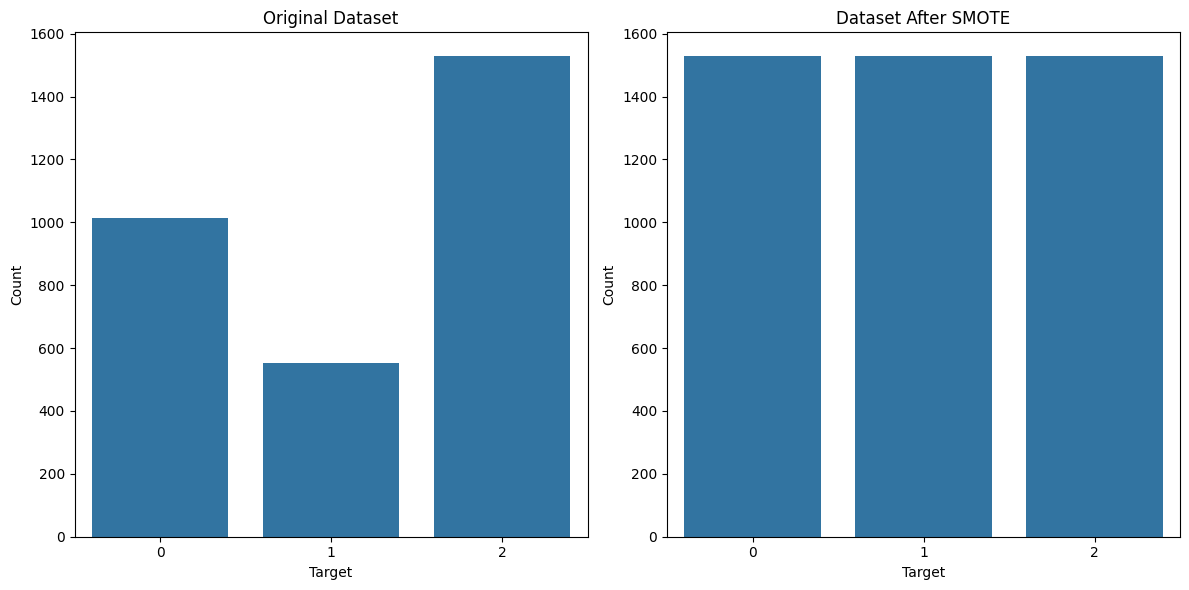

In [203]:
X_train, X_test, y_train, y_test = manual_split(df1, target_column='Target')

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Plot the dataset before and after SMOTE
plot_dataset_before_after_smote(X_train, y_train, X_resampled, y_resampled)


In [223]:
# Convert the resampled X and y arrays into a DataFrame
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame({'y': y_resampled})], axis=1)

# Export the DataFrame to a CSV file
resampled_df.to_csv('DvA_resampled_dataset.csv', index=False)


In [210]:
def evaluate_model(model, X_test, y_test):
    if isinstance(model, OneClassSVM):
        y_pred = model.predict(X_test)
        accuracy = None  # Since OneClassSVM doesn't provide accuracy
        classification_rep = None  # No classification report available
        roc_auc = None  # No ROC AUC available
    else:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        
        # Check if the model supports predict_proba method
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)
            if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
                # For binary classification, use ROC AUC for positive class
                if len(np.unique(y_test)) == 2:  # Binary classification
                    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
                else:  # Multi-class classification
                    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
            else:
                # For multi-class classification, use ROC AUC
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        else:
            roc_auc = None

    return accuracy, classification_rep, roc_auc


## Random Forest Classifier (Data Technique)

In [2]:
def model_selection():
    model = RandomForestClassifier()  
    print('Random Forest Classifier') 
    return model

In [213]:
master_pipeline_with_smote(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\1176217534.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})


Random Forest Classifier

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.869
F1 -ve: 0.781
AUC: 0.897
Accuracy: 0.787

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.773
Fold 2: 0.762
Fold 3: 0.842
Fold 4: 0.880
Fold 5: 0.872

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.868
F1 -ve: 0.775
AUC: 0.898
Accuracy: 0.781


## Gradient Boosting (Data Technique)

In [214]:

def model_selection():
    model = GradientBoostingClassifier()
    print('Gradient Boosting Classifier')
    return model

In [215]:
master_pipeline_with_smote(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\1176217534.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})


Gradient Boosting Classifier

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.873
F1 -ve: 0.782
AUC: 0.900
Accuracy: 0.791

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.728
Fold 2: 0.722
Fold 3: 0.815
Fold 4: 0.847
Fold 5: 0.836

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.873
F1 -ve: 0.782
AUC: 0.900
Accuracy: 0.791


## Naive Bayes (Data Technique)

In [216]:

def model_selection():
    model = GaussianNB() 
    print('Naive Bayes')  
    return model

In [217]:
master_pipeline_with_smote(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\1176217534.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})


Naive Bayes

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.688
F1 -ve: 0.710
AUC: 0.784
Accuracy: 0.617

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.588
Fold 2: 0.600
Fold 3: 0.699
Fold 4: 0.678
Fold 5: 0.693

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.688
F1 -ve: 0.710
AUC: 0.784
Accuracy: 0.617


## Logistic Regression (Data Technique)

In [218]:

def model_selection():
    model = LogisticRegression()  
    print('Logistic Regression') 
    return model

In [219]:
master_pipeline_with_smote(filepath, target)

Logistic Regression

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\1176217534.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Results without Cross-Validation:
F1 +ve: 0.783
F1 -ve: 0.672
AUC: 0.794
Accuracy: 0.673

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.


Cross-Validation Scores:
Fold 1: 0.626
Fold 2: 0.602
Fold 3: 0.623
Fold 4: 0.626
Fold 5: 0.662

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.783
F1 -ve: 0.672
AUC: 0.794
Accuracy: 0.673


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Decision Trees (Data Technique)

In [220]:

def model_selection():
    model = DecisionTreeClassifier()  
    print('Decision Tree Classifier') 
    return model

In [221]:
master_pipeline_with_smote(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_14436\1176217534.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Target'] = df['Target'].replace({'Graduate': 1, 'Dropout': 0,'Enrolled':2})


Decision Tree Classifier

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.758
F1 -ve: 0.682
AUC: 0.711
Accuracy: 0.649

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.655
Fold 2: 0.654
Fold 3: 0.745
Fold 4: 0.751
Fold 5: 0.751

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.768
F1 -ve: 0.697
AUC: 0.722
Accuracy: 0.665


## Results

### Class Imbalance (Data Technique)
|          | Logistic Regression | Naïve Bayes | Decision Tree | Random Forest Classifier | Gradient Boosting |
|------------------------|---------------------|-------------|---------------|--------------------------|-------------------|
| F1 +ve                 | 0.783               | 0.688       | 0.768         | 0.722                    | 0.781             |
| F1-ve                  | 0.672               | 0.710       | 0.617         | 0.665                    | 0.873             |
| AUC                    | 0.794               | 0.784       | 0.697         | 0.868                    | 0.782             |
| Accuracy               | 0.673               | 0.617       | 0.722         | 0.775                    | 0.900             |


# 1